# Python Tale
## Multilayer RNN for Character Prediction

### Outline
    - Overview
    - Architecture
    - Data
    - Code
        - Data Generator
        - RNN Model
        - RNN Char Model
    - Predictions
    - Future Work
    - Conclusion

### Overview

I have created a generalized multilayer RNN for character prediction class that can accept as many files containing text as you want, and will train a RNN of as many layers as you'd like for any length sequence you would like using your choice of LSTM, GRU or ELMAN gates, using your choice of optimizer.  The RNN will be able to generate predictions at the character level, and if trained adequately will be able to generate its own TensorFlow code to writing Shakespeare esque plays. 

### Architecture

This architecture was inspired by Karpathy's [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) on the effectiveness of RNNs.  In the post Karpathy outlines how to create a single layer RNN with ELMAN gates to generate a character prediction for every time step.
<img src="Images/charseq.jpg">
Image Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/




There are three changes I have made to this architecture:
    - I allowed for the LSTM, GRU, or the ELMAN gate to be used
        - LSTM's and GRU's allow for the gradient to flow further back in time allowing for better learning and in               
          turn better predictions
    - I allowed for arbitrary number of layers
        - Increasing the number of layers allow for more complexity to be expressed in the weights generating better               
          predictions
    - I allowed for the number of predictions per sequence to become a hyperparameter
        - Changing the predictions from being for every time step to every nth time step ensures a there is a               
          minimum context of n characters before a prediction is made allowing for potentially better predictions          
          

### Data

Unfortunately, AWS rejected my request to use a GPU instance.  Therefore, I was forced to use to train my multilayer rnn on cpus.  Due to the significant slowdown from training on cpus I had to cut back significantly on my dataset to be able to train my net in a reasonable amount of time.  For this reason, I could not not train my net on the TensorFlow Github repository as I originally intended and instead I trained my net on Shakespeare's Hamlet.  Hence, the code below is applied to Hamlet, but is generalized so that you are able to run this code on any file containing text.

I have generated three plots below showing the most common characters, most common strings of length 20 and most common strings of length 2 for Hamlet.

In [2]:
from collections import Counter
import glob
from itertools import chain
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb
%matplotlib inline

class EDA_RNN_Text(object):
    """
    generate exploraty plots for text data
    
    Parameters
    ----------
    file_names: List of Strings; location of the text files that you'd like the RNN to train on
    len_sequence: Integer; length of sequence of strings to be generated for plot_top_str
    
    Attributes
    ----------
    data: number of sequences x len_sequence numpy array; matrix where each row is the byte representation
                                                          of a len_sequence number of characters
    """
    
    def __init__(self, file_names, len_sequence=4):
        self.file_names = file_names
        self.len_sequence = len_sequence
        self.data = self.get_data()
        
    def get_data(self):
        """
        takes list of file_names -> grabs text from each file -> converts byte form -> generates sequences
        of length length_sequence -> concatenates all sequences into one numpy array
        
        Parameters
        ----------
        None
        
        Returns
        -------
        data: number of sequences x len_sequence numpy array; matrix where each row is the byte representation
                                                              of a len_sequence number of characters
        """
        def read_file(file_name):
            """
            grabs the text from a document
        
            Parameters
            ----------
            file_name: string; location of a file

            Returns
            -------
            string; text in the document
            """
            with open(file_name) as f:
                return f.read()
            
        list_files = map(glob.glob, self.file_names)
        py_files = reduce(lambda i, j: i+j, list_files)
        list_accum = map(read_file, py_files)
        la_filter = filter(lambda x: len(x)>0, list_accum)
        list_bytes = map(lambda i: map(ord,i), la_filter)
        list_list_bytes = map(lambda x: [x[i:i+self.len_sequence] for i in range(0,len(x)-self.len_sequence+1)]
                              ,list_bytes)
        data = np.array(list(chain.from_iterable(list_list_bytes)))#http://stackoverflow.com/questions/35004945/python-pandas-reduce-function-for-series
        return data
        
    def plot_top_char(self, top_number = 50):
        """
        barplot for the top_number characters with the largest counts
        
        Parameters
        ----------
        top_number: Integer; number of characters with the highest count to plot
        
        Returns
        -------
        None; produces barplot for the top_number characters with the largest counts                                                              
        """
        ll = list(chain(*self.data))
        mm = Counter(ll)
        most_com = mm.most_common(top_number)
        char = map(chr,[i[0] for i in most_com])
        plt.figure(figsize = (15,15))
        sb.barplot(char,[i[1] for i in most_com])
        plt.title("Top %s Characters"%(top_number))
        plt.show()
        
    def plot_top_str(self, top_number = 30):
        """
        barplot for the top_number strings of length len_sequence with the largest counts
        
        Parameters
        ----------
        top_number: Integer; number of strings with the highest count to plot
        
        Returns
        -------
        None; produces barplot for the top_number strings of length len_sequence with the largest counts 
        """
        list_n = map(lambda i: list(self.data[i]), range(self.data.shape[0]))
        str_n = map(lambda i: ",".join(map(str,i)),list_n)
        dict_n = Counter(str_n)
        top_list = dict_n.most_common(top_number)
        top_str = map(lambda j: ''.join(map(lambda i: chr(int(i)),j[0].split(","))), top_list)
        plt.figure(figsize = (15,15))
        sb.barplot(top_str, [i[1] for i in top_list])
        plt.title("Top %s Strings of Length %s"%(top_number,self.len_sequence))
        plt.show()

In [3]:
ert = EDA_RNN_Text(["Data/shakespeare-hamlet.txt"], len_sequence= 20)

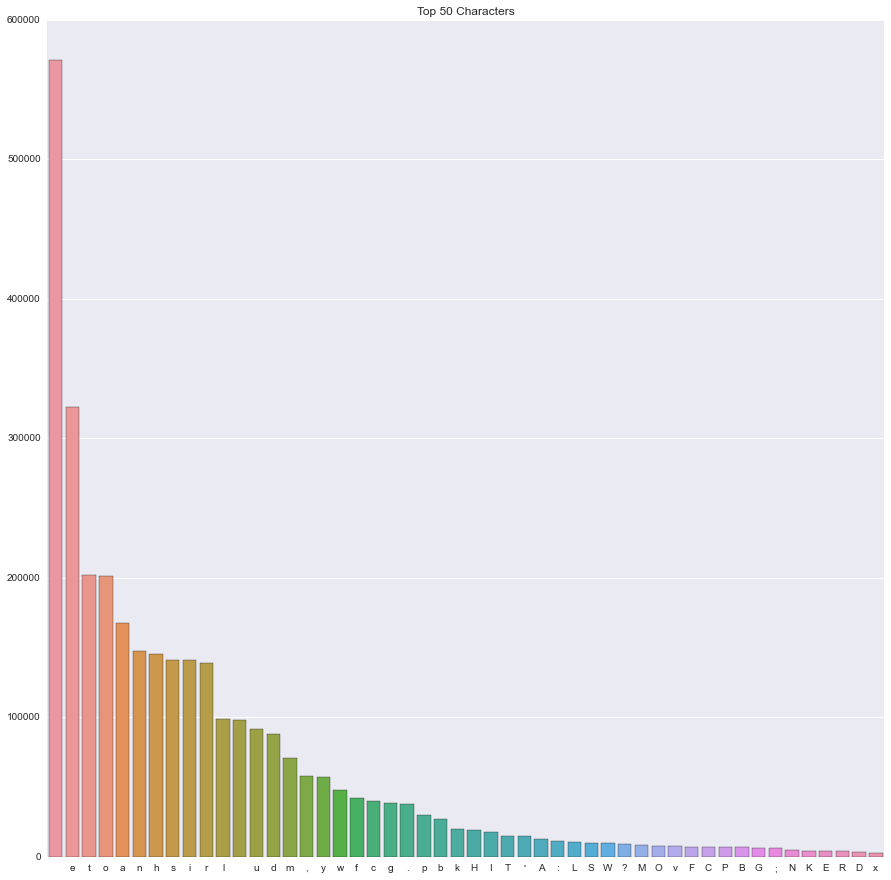

In [409]:
ert.plot_top_char()

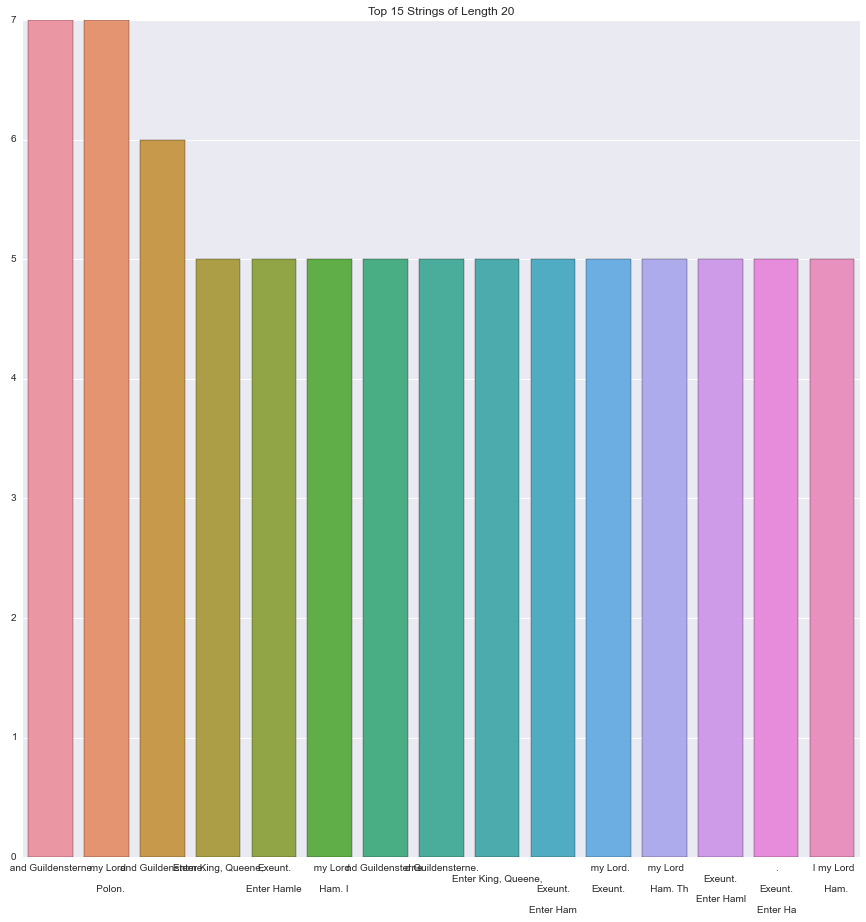

In [410]:
ert.plot_top_str(top_number=15)

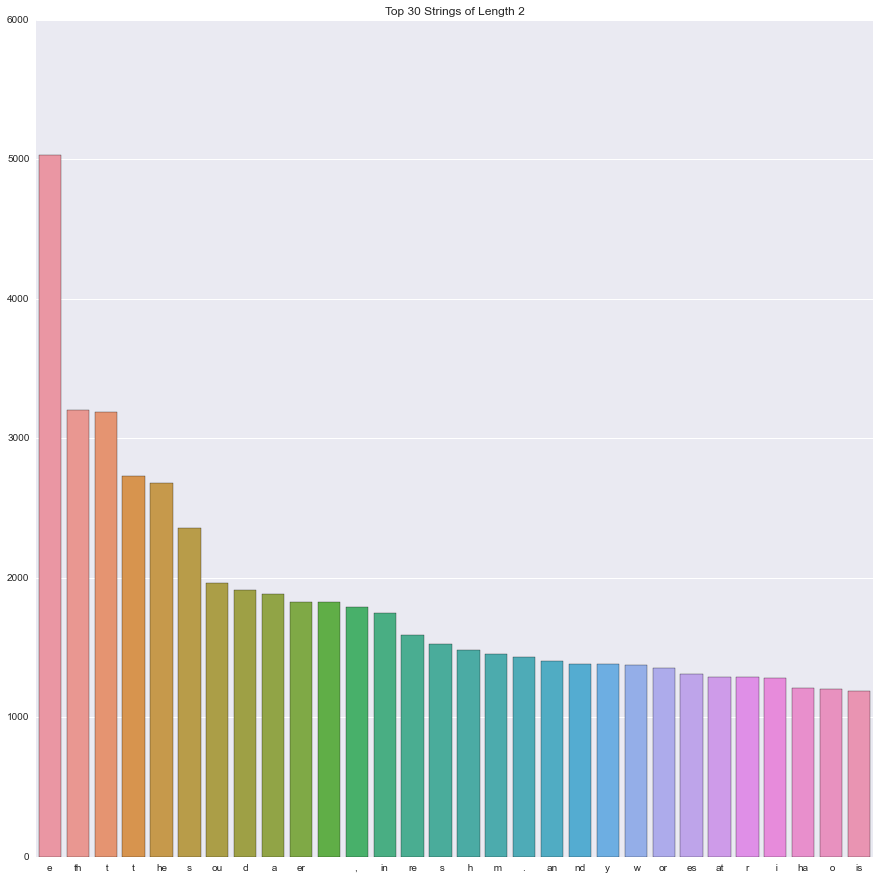

In [411]:
EDA_RNN_Text(["Data/shakespeare-hamlet.txt"],
             len_sequence= 2).plot_top_str()

### Code

The code is broken up into three parts
    
    1) Data Generator - creates a test train split on the data and a data generator to ensure the model gets every            
                        observation once for each epoch
    2) RNN Model - creates a multilayer RNN composed with the type of gates specified by the user in TensorFlow
    3) RNN Char Model - combines the Data Generator and RNN Model to train the multilayer rnn and makes character                             
                        level predictions based on the multilayer RNN

#### Data Generator

Creates a test train split on the data and a data generator to ensure the model gets every observation once for each epoch.

In [458]:
import glob
from itertools import chain
import numpy as np
import pandas as pd
import tensorflow as tf

class RNN_Text_Generator(object):
    """
    Data generator for text data to be input for a RNN.
    Creates a test-train split of the data.
    
    Parameters
    ----------
    file_names : list of strings; location of the text files that you'd like the RNN to train on
    len_sequence: integer; length of sequence for the RNN where len_sequence - 1 elements are input to
                           the RNN and the last element is the target output of the RNN
    mini_batch_size: integer; number of elements to include for each minibatch produced by the
                              data_generator function
    test_train_split: float; percent of data you want to use for the training set
    
    Attributes
    ----------
    data: number of sequences x len_sequence numpy array; matrix where each row is the byte representation
                                                          of a len_sequence number of characters
    len_data: integer; total number of sequences in the dataset
    mini_batch_index: integer; counter used to keep track which subset of the data to send for the next call of
                               data_generator
    mn: integer; smallest byte value observed in the data
    mx: integer; largest byte value observed in the data
    train_num: integer; number of training observations
    train_range: list of integers; list containing all values between 0 and train_num-1 inclusively
    x_test: numpy array; test input for the RNN in byte form
    x_train: numpy array; training input for the RNN in byte form
    y_test: numpy array; test target ouput for the RNN in byte form
    y_train: numpy array; training target ouput for the RNN in byte form                          
    """
    
    def __init__(self, file_names, len_sequence = 10,pred_len = 2, mini_batch_size = 200, test_train_split = .7):
        self.file_names = file_names
        self.pred_len = pred_len
        self.len_sequence = len_sequence
        self.test_train_split = test_train_split
        self.x, self.y, self.mn, self.mx = self.get_data()
        self.len_data = len(self.x)
        self.x_train, self.y_train, self.x_test, self.y_test, self.train_num = self.split_data()
        self.train_range = range(self.train_num)
        self.mini_batch_size = mini_batch_size
        self.mini_batch_index = 0

    def get_data(self):
        """
        takes list of file_names -> grabs text from each file -> converts byte form -> generates sequences
        of length length_sequence -> concatenates all sequences into one numpy array
        
        Parameters
        ----------
        None
        
        Returns
        -------
        data: number of sequences x len_sequence numpy array; matrix where each row is the byte representation
                                                              of a len_sequence number of characters
        mn: integer; smallest byte value observed in the data
        mx: integer; largest byte value observed in the data
        """
        def read_file(file_name):
            """
            grabs the text from a document
        
            Parameters
            ----------
            file_name: string; location of a file

            Returns
            -------
            string; text in the document
            """
            with open(file_name) as f:
                return f.read()
            
        list_files = map(glob.glob, self.file_names)
        py_files = reduce(lambda i, j: i+j, list_files)
        list_accum = map(read_file, py_files)
        la_filter = filter(lambda x: len(x)>0, list_accum)
        list_bytes = map(lambda i: map(ord,i), la_filter)
        mn = min(map(lambda i: min(i), list_bytes))
        mx = max(map(lambda i: max(i), list_bytes))
        list_list_bytes = map(lambda x: [(x[i:i+self.len_sequence],map(lambda j: x[j],range(i+self.pred_len,i+self.pred_len+self.len_sequence,self.pred_len))) for i in range(0,len(x)-self.len_sequence-self.pred_len+1)]
                              ,list_bytes)
        concat_l = list(chain.from_iterable(list_list_bytes))
        list_x = [i[0] for i in concat_l]
        list_y = [i[1] for i in concat_l]
        x,y = np.array(list_x),np.array(list_y)#http://stackoverflow.com/questions/35004945/python-pandas-reduce-function-for-series
        return x,y, mn, mx
    
    def split_data(self):
        """
        Splits the data into the train and test sets then splits the inputs from the output
        
        Parameters
        ----------
        None
        
        Returns
        -------
        x_train: numpy array; training input for the RNN in byte form
        y_train: numpy array; training target ouput for the RNN in byte form
        x_test: numpy array; test input for the RNN in byte form
        y_test: numpy array; test target ouput for the RNN in byte form
        train_num: integer; number of training observations
        """
        rng = np.array(range(self.len_data))
        np.random.shuffle(rng)
        train_num = int(self.test_train_split*self.len_data)
        train_index, test_index = rng[:train_num], rng[train_num:]
        x_train, y_train, x_test, y_test = self.x[train_index], self.y[train_index], self.x[test_index], self.y[test_index]
        return x_train, y_train, x_test, y_test, train_num
    
    def one_hot_map(self,lst):
        """
        takes a list of bytes -> create one hot encoded vector for each byte -> concatenate all byte vectors
        
        Parameters
        ----------
        lst: list of integers; list of length length_seq containing the byte reprsentation for each char in the
                               sequence
        
        Returns
        -------
        numpy array; contains the matrix of one hot encoded characters
        """
        def one_hot_char(num):
            """
            one hot encodes each character based on its byte representation
        
            Parameters
            ----------
            num: integer; byte representation for a given character

            Returns
            -------
            z: numpy array; the one hot encoding for the given character's byte representation
            """
            num_adj = num - self.mn 
            z = np.zeros((1,self.mx - self.mn + 1))
            z[0,num_adj] = 1.0
            return z
        lst_one_hot = map(one_hot_char,lst)
        return np.vstack(lst_one_hot)
    
    def data_generator(self):
        """
        data generator for RNN produces a minibatch tensor of input and the corresponding output numpy array
        data generator will not pass the same observation until all other observations have been returned
        
        Parameters
        ----------
        None
        
        Returns
        -------
        x_mb: 3 dimensional numpy array; minibatch of training input data
        y_mb: 2 dimensional numpy array; minibatch of training output data
        """
        min_index = self.mini_batch_index * self.mini_batch_size % self.train_num 
        if(min_index+self.mini_batch_size>= self.train_num):
            max_rng = np.array(range(min_index,self.train_num))
            add_num = self.mini_batch_size-len(max_rng)
            add_idx = np.random.choice(range(self.train_num), size = add_num, replace = False)
            idx_stack = np.hstack([max_rng,add_idx])
            xt = self.x_train[idx_stack]
            yt = self.y_train[idx_stack]
        else:
            max_index = min_index+self.mini_batch_size
            xt = self.x_train[min_index:max_index]
            yt = self.y_train[min_index:max_index]
        self.mini_batch_index+=1
        x_mb = np.vstack(map(self.one_hot_map,xt)).reshape(self.mini_batch_size, self.len_sequence, self.mx-self.mn+1)
        y_mb = np.vstack(map(self.one_hot_map,yt)).reshape(self.mini_batch_size, self.len_sequence/self.pred_len, self.mx-self.mn+1)
        return x_mb, y_mb
    

#### RNN Model

Creates a multilayer RNN composed with the type of gates specified by the user in TensorFlow.

In [459]:
class RNN_Model(object):
    """
    creates a multilayer rnn model with either Elman, GRU or LSTM gates in TensorFlow 
    based on parameters passed by user
    
    Parameters
    ----------
    h_size: integer; size of the hidden layer
    input_size: integer; size of the input layer
    n_layers: integer; number of layers for the RNN
    act: TensorFlow activation function; activation function to use for an Elman net
    classification: Boolean; True -> Produce a classification RNN
                             False -> Produce a regression RNN
    final_step: String; type of prediction you'd like to make:
                                                               "last" -> use only the last output from last time step
                                                                         to make prediction
                                                                other -> use output from all time steps to make 
                                                                         predictions
    gate: String; type of gate function you want used for RNN either "ELMAN", "GRU" or "LSTM"
    optimizer: TensorFlow optimization function; optimizer to be used to train the RNN
    pred_len: Integer; make a prediction at the pred_len time step
    target_size: Integer or None; size of the prediction if None it will be equal to input_size
    
    Attributes
    ----------
    gate_func: function; gate function you want used for RNN either f_ELMAN, f_GRU or f_LSTM                       
    """
    def __init__(self, h_size, input_size, n_layers, act = tf.nn.relu, classification= True, final_step = "last", 
                 gate = "LSTM", mini_batch_size = 200,optimizer = tf.train.AdamOptimizer(), pred_len = 2, target_size = None):
        gate_dict = {"LSTM": self.f_LSTM, "GRU": self.f_GRU, "ELMAN": self.f_ELMAN}
        self.h_size = h_size
        self.input_size = input_size
        self.n_layers = n_layers
        self.optimizer = optimizer
        self.pred_len = 2
        self.act = act
        self.classification = classification
        self.final_step = final_step
        self.gate = gate
        self.gate_func = gate_dict[gate]
        self.mini_batch_size = mini_batch_size
        if target_size is None:
            self.target_size = input_size
        else:
            self.target_size = target_size
        
    def generate_model(self):
        """
        creates a multilayer RNN model based on the parameters used to instantiate the class
        
        Parameters
        ----------
        None
        
        Returns
        -------
        inputs: TensorFlow Placeholder; placeholder for the data to be used as the input layer
        y: TensorFlow Placeholder; placeholder for the target output
        initial_hidden: TensorFlow Placeholder; placeholder for the data to be used as hidden 
                                                layer data for time step 0
        train_step: Tensor action produces Null; action that will train the RNN 
                                                 REQUIRES: inputs, y, initial_hidden specified in the feed_dict
        accuracy: Tensor action produces double; action that will produce the accuracy for the data passed into the RNN
                                                 REQUIRES: inputs, y, initial_hidden specified in the feed_dict
        y_hat: Tensor action produces array; action produce the prediction(s) of the RNN for the data passed into the RNN
                                                 REQUIRES: inputs, initial_hidden specified in the feed_dict
        tf.train.Saver(); instance used to either save the TensorFlow session or upload a saved TensorFlow session
        """
        inputs = tf.placeholder(tf.float32, shape=[self.mini_batch_size,None, self.input_size], name = 'inputs')
        inputs_ = tf.transpose(inputs, perm = [1, 0, 2])
        if self.gate == "LSTM":
            initial_hidden = tf.placeholder(tf.float32, shape = [None, 2*self.n_layers*self.h_size])
        else:
            initial_hidden = tf.placeholder(tf.float32, shape = [None, self.n_layers*self.h_size])
        y = tf.placeholder(tf.float32, shape=[self.mini_batch_size,None,  self.target_size], name = "y")
        
        if self.final_step == "last":
            final_step_func = self.last_final_step()
        else:
            final_step_func = self.multi_final_step()
        
        multi_layer = self.multi_layer_general(self.input_size)
        all_hidden_states = tf.scan(multi_layer, inputs_, initializer = initial_hidden, name = "LSTM_H")
        loss, y_hat, _ = final_step_func(all_hidden_states,y)
        train_step = self.optimizer.minimize(loss)
        correct_pred = tf.equal(tf.argmax(y_hat,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        return inputs, y, initial_hidden, train_step, accuracy, y_hat, all_hidden_states, tf.train.Saver()

    def f_ELMAN(self, i_size, name_scope = "gru_recursion", sd = .01):
        """
        generates a single layer of an Elman net
        
        Parameters
        ----------
        i_size: Integer; input size for the given layer of the Elman net
        name_scope: String; the name scope to be passed to tf.name_scope
        sd: Double; standard deviation used to initialize the weight matricies and vector 
        
        Returns
        -------
        fR: function; function to perform the actions of a single layer of an Elman net
        """
        with tf.name_scope(name_scope) as scope:
            W = tf.Variable(tf.truncated_normal([i_size, self.h_size], stddev = sd), name = "W")
            U = tf.Variable(tf.truncated_normal([self.h_size, self.h_size], stddev = sd), name = "U")
            b = tf.Variable(tf.zeros([self.h_size]), name = "b") 
            def fR(stateTm1, x):
                """
                performs Elman gate operation on given weights and inputs
        
                Parameters
                ----------
                stateTm1: TensorFlow Vector; output from hidden state at previous time step
                x: TensorFlow Vector; input vector at same time step


                Returns
                -------
                TensorFlow vector; result of performing Elman gate operation on given weights and inputs
                """
                return self.act(tf.matmul(x, W) + tf.matmul(stateTm1, U) + b)

            return fR    


    def f_GRU(self, i_size, name_scope = "gru_recursion", sd = .01):
        """
        generates a single layer of a GRU net
        
        Parameters
        ----------
        i_size: Integer; input size for the given layer of the Elman net
        name_scope: String; the name scope to be passed to tf.name_scope
        sd: Double; standard deviation used to initialize the weight matricies and vector 
        
        
        Returns
        -------
        fR: function; function to perform the actions of a single layer of an GRU net
        """
        def generate_variable_names(i):
            """
            generate all variable names for given type of weight
        
            Parameters
            ----------
            i: String; type of weight

            Returns
            -------
            [i+"_"+j for j in list_stages]; list of all variable names for given weight type
            """
            list_stages = ["z", "r", "h"]
            return [i+"_"+j for j in list_stages]

        weight_prefixes = ["W", "U", "b"]
        W_list, U_list, b_list = map(lambda i: generate_variable_names(i), weight_prefixes)

        with tf.name_scope(name_scope) as scope:
            W_dictionary = {i : tf.Variable(tf.truncated_normal([i_size, self.h_size], stddev = sd), name = i)
                                for i in W_list}
            U_dictionary = {i : tf.Variable(tf.truncated_normal([self.h_size, self.h_size], stddev = sd), name = i)
                                for i in U_list}
            b_dictionary = {i : tf.Variable(tf.zeros([self.h_size]), name = i) for i in b_list}

            def fR(stateTm1, x):
                """
                performs GRU gate operations on given weights and inputs
        
                Parameters
                ----------
                stateTm1: TensorFlow Vector; output from hidden state at previous time step
                x: TensorFlow Vector; input vector at same time step 


                Returns
                -------
                TensorFlow vector; result of performing GRU gate operations on given weights and inputs
                """
                def activate_affine(typ, act, mult):
                    """
                    perform affine transformation and then activation function for the given step of the GRU gate
        
                    Parameters
                    ----------
                    typ: String; the step of the GRU gate being performed
                    act: TensorFlow activaton function; the activation function to be performed on 
                                                        the affine transformation
                    mult: Integer of TensorFlow vector; value to multiply the matrix multiplication of hidden state
                                                        and its weight by, exists for the h step

                    Returns
                    -------
                    returns the vector produced by performing the activation on the affine transformation for the given
                    GRU step
                    """
                    return act(tf.matmul(x, W_dictionary["W_"+typ])+(mult*tf.matmul(h, U_dictionary["U_"+typ]))+
                                   b_dictionary["b_"+typ])

                h = stateTm1
                z = activate_affine("z", tf.sigmoid, 1)
                r = activate_affine("r", tf.sigmoid, 1)
                h_prime = activate_affine("h", tf.nn.tanh, r)
                ht = z*h + (1-z)*h_prime
                return ht
            return fR
    
    def f_LSTM(self, i_size, name_scope = "lstm_recursion", sd = .01):
        """
        generates a single layer of a LSTM net
        
        Parameters
        ----------
        i_size: Integer; input size for the given layer of the Elman net
        name_scope: String; the name scope to be passed to tf.name_scope
        sd: Double; standard deviation used to initialize the weight matricies and vector 
        
        
        Returns
        -------
        fR: function; function to perform the actions of a single layer of an LSTM net
        """
        def generate_variable_names(i):
            """
            generate all variable names for given type of weight
        
            Parameters
            ----------
            i: String; type of weight

            Returns
            -------
            [i+"_"+j for j in list_stages]; list of all variable names for given weight type
            """
            list_stages = ["i", "f", "o", "c"]
            return [i+"_"+j for j in list_stages]

        weight_prefixes = ["W", "U", "b"]
        W_list, U_list, b_list = map(lambda i: generate_variable_names(i), weight_prefixes)

        with tf.name_scope(name_scope) as scope:
            W_dictionary = {i : tf.Variable(tf.truncated_normal([i_size, self.h_size], stddev = sd), name = i)
                                for i in W_list}
            U_dictionary = {i : tf.Variable(tf.truncated_normal([self.h_size, self.h_size], stddev = sd), name = i)
                                for i in U_list}
            b_dictionary = {i : tf.Variable(tf.zeros([self.h_size]), name = i) for i in b_list}

            def fR(stateTm1, x):
                """
                performs LSTM gate operations on given weights and inputs
        
                Parameters
                ----------
                stateTm1: TensorFlow Vector; contains h and c vectors from the hidden state at previous time step 
                x: TensorFlow Vector; input vector at same time step 



                Returns
                -------
                TensorFlow vector; result of performing LSTM gate operations on given weights and inputs
                """
                def activate_affine(typ, act):
                    """
                    perform affine transformation and then activation function for the given step of the LSTM gate
        
                    Parameters
                    ----------
                    typ: String; the step of the LSTM gate being performed
                    act: TensorFlow activaton function; the activation function to be performed on 
                                                        the affine transformation
                    mult: Integer of TensorFlow vector; value to multiply the matrix multiplication of hidden state
                                                        and its weight by, exists for the h step

                    Returns
                    -------
                    returns the vector produced by performing the activation on the affine transformation for the given
                    LSTM step
                    """
                    return act(tf.matmul(x, W_dictionary["W_"+typ])+tf.matmul(h, U_dictionary["U_"+typ])+
                                   b_dictionary["b_"+typ])

                h, c = tf.split(1, 2, stateTm1)
                list_computations = [("i", tf.sigmoid), ("f", tf.sigmoid), ("o", tf.sigmoid), ("c", tf.nn.tanh)]
                i, f, o, c_squig = map(lambda (i, j): activate_affine(i, j), list_computations)
                ct = f*c + i*c_squig
                ht = o*tf.nn.tanh(ct)
                return tf.concat(1, [ht, ct])
            return fR
        
    def multi_layer_general(self, i_size):
        """
        generates a multilayer RNN composed of the type of gated functions specified by the class instantiation
        
        Parameters
        ----------
        i_size: integer; input size for the RNN
        
        Returns
        -------
        fR: function; returns function to perform the actions of multilayer RNN composed of the type of gated 
                      functions specified by the class instantiation
        """
        name_spaces = ["Recursion_"+str(i) for i in xrange(self.n_layers)]
        layers = [self.gate_func(i_size, name_spaces[0])]+[self.gate_func(self.h_size, name_spaces[i]) for i in range(1, self.n_layers)]

        def fR(stateTm1, x):
            """
            performs the actions of multilayer RNN composed of the type of gated functions specified by 
            the class instantiation
        
            Parameters
            ----------
            stateTm1: TensorFlow Vector; output from hidden state at previous time step for all n_layers
            x: TensorFlow Vector; input vector at same time step



            Returns
            -------
            state_list: TensorFlow Vector; concatenation of output vectors for each layer
            """
            h_list = tf.split(1, self.n_layers, stateTm1)
            new_state = layers[0](h_list[0],x)
            state_list = new_state
            for i in range(1, self.n_layers):
                if self.gate == "LSTM":
                    new_h, _ = tf.split(1, 2, new_state)
                else:
                    new_h = new_state
                new_state = layers[i](h_list[i],new_h)
                state_list = tf.concat(1,[state_list, new_state])
            return state_list
        return fR
        
    def last_final_step(self):
        """
        creates a function that takes the output at the last time step from the rnn 
        performs an affine transformation producing the prediction for the rnn and calculates the loss
        
        Parameters
        ----------
        None
        
        Returns
        -------
        final_step_func: function; generates function that takes the output at the last time step from the rnn
                                   performs an affine transformation producing the prediction for the rnn and
                                   calculates the loss
        """
        W_last = tf.Variable(tf.truncated_normal([self.h_size, self.target_size], mean = 0, stddev = 0.01),
                                                                                              name = "W_last")
        b_last = tf.Variable(tf.truncated_normal([self.target_size], mean = 0, stddev = 0.01), name = "b_last")
            
        def final_step_func(all_hidden_states,y):
            """
            produces the prediction for the rnn and calculates the loss
        
            Parameters
            ----------
            all_hidden_states: TensorFlow Vector; contains all output from each time step from the rnn
            y: TensorFlow matrix; the target ouputs for the rnn

            Returns
            -------
            l: Double; the loss of the rnn for the given data
            y_hat: matrix; all the predictions for the given data
            """
            last_hidden_state = tf.reverse(all_hidden_states, [True, False, False])[0, :, :]
            if self.gate == "LSTM":
                lay = tf.split(1,2*self.n_layers,last_hidden_state)
                last_h = lay[-2]
            else:
                lay = tf.split(1,self.n_layers,last_hidden_state)
                last_h = lay[-1]
            affine_transform = tf.matmul(last_h, W_last) + b_last
            if self.classification:
                y_hat = tf.nn.softmax(affine_transform)
                l = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_hat))) 
            else:
                y_hat = affine_transform
                l = tf.sqrt(tf.reduce_mean(tf.reduce_sum((y-y_hat)**2.0)))
            return l, y_hat, last_h         
        return final_step_func
    
    def multi_final_step(self):
        """
        creates a function that takes the output at each time step(where time step %pred_len ==0) from the rnn 
        performs an affine transformation producing the predictions for the rnn and calculates the loss
        
        Parameters
        ----------
        None
        
        Returns
        -------
        final_step_func: function; generates function that takes the outputat each time step
                                   (where time step %pred_len ==0)  from the rnn performs an affine
                                   transformation producing the prediction for the rnn and
                                   calculates the loss
        """
        W_last = tf.Variable(tf.truncated_normal([self.h_size, self.target_size], mean = 0, stddev = 0.01),
                                                                                              name = "W_last")
        b_last = tf.Variable(tf.truncated_normal([self.target_size], mean = 0, stddev = 0.01), name = "b_last")
            
        def final_step_func(all_hidden_states,y):
            """
            produces the predictions for the rnn and calculates the loss
        
            Parameters
            ----------
            all_hidden_states: TensorFlow Vector; contains all output from each time step from the rnn
            y: TensorFlow matrix; the target ouputs for the rnn

            Returns
            -------
            l: Double; the loss of the rnn for the given data
            y_hat: tensor; all the predictions for the given data
            """
            last_hidden_state = tf.reverse(all_hidden_states, [True, False, False])[::self.pred_len, :, :][::-1,:,:]
            #last_hidden_state = [tf.reverse(all_hidden_states, [True, False, False])[i, :, :] for i in range(0,len_seq,self.pred_len)]
            if self.gate == "LSTM":
                last_h = tf.split(2,2*self.n_layers,last_hidden_state)[-1]
            else:
                last_h = tf.split(2,self.n_layers,last_hidden_state)[-1]
            affine_transform = tf.einsum("ijk,kl->ijl",last_h, W_last) + b_last 
            if self.classification:
                logit = tf.nn.softmax(affine_transform)
                y_hat = tf.transpose(logit,[1,0,2])
                l = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y_hat)))
            else:
                y_hat = tf.transpose(logit,[1,0,2])
                l = tf.sqrt(tf.reduce_mean(tf.reduce_sum((y[i]-y_hat[i])**2.0)))
            return l, y_hat, last_h         
        return final_step_func        

#### RNN Char Model

Combines the Data Generator and RNN Model to train the multilayer rnn and makes character level predictions based on the multilayer RNN.

In [460]:
class RNN_Next_Char(object):
    """
    Creates a multi-layer RNN with the type of gate specified to predict the next character
    
    Parameters
    ----------
    file_names : list of strings; location of the text files that you'd like the RNN to train on
    h_size: integer; size of the hidden layer
    n_layers: integer; number of layers for the RNN
    act: TensorFlow activation function; activation function to use for an Elman net
    final_step: String; type of prediction you'd like to make:
                                                               "last" -> use only the last output from last time step
                                                                         to make prediction
                                                                other -> use output from all time steps to make 
                                                                         predictions
    gate: String; type of gate function you want used for RNN either "ELMAN", "GRU" or "LSTM"
    len_sequence: integer; length of sequence for the RNN where len_sequence - 1 elements are input to
                           the RNN and the last element is the target output of the RNN
    mini_batch_size: integer; number of elements to include for each minibatch produced by the
                              data_generator function
    optimizer: TensorFlow optimization function; optimizer to be used to train the RNN
    pred_len: Integer; make a prediction at the pred_len time step
    test_train_split: float; percent of data you want to use for the training set
    
    Attributes
    ----------
    rnn_tg: instance of RNN_Text_Generator; Data generator for text data to be input for a RNN. 
            Creates a test-train split of the data.
    model: instance of RNN_Model; creates a multilayer rnn model with either Elman, GRU or LSTM 
                                  gates in TensorFlow based on parameters passed by user
    sess_list: list; holds the location of all the models that were checkpointed 
    """
    def __init__(self, file_names, h_size, n_layers, act = tf.nn.relu, final_step = "multi", 
                 gate = "LSTM", len_sequence = 10, mini_batch_size = 200,
                 optimizer = tf.train.AdamOptimizer(), pred_len=2, test_train_split = .7):
        self.rnn_tg = RNN_Text_Generator(file_names, len_sequence, pred_len, mini_batch_size,test_train_split)
        self.model = RNN_Model(h_size, self.rnn_tg.mx-self.rnn_tg.mn+1, n_layers, act, final_step= final_step,
                               gate= gate, mini_batch_size = mini_batch_size, optimizer= optimizer, pred_len = pred_len)
        self.pred_len = pred_len
        self.sess_list = []
        
    
    def train(self, sess_directory, epochs = 10):
        """
        trains the multilayer rnn
        
        Parameters
        ----------
        sess_directory: String; location where you want the checkpointed models to be saved to
        epochs: Integer; Number of times you want to iterate through all the data
        
        Returns
        -------
        Null; Model is checkpointed after each epoch and the locations of each checkpoint is stored in sess_list
        """
        tf.reset_default_graph()
        inputs, y, initial_hidden, train_step, accuracy, y_hat, _, saver = self.model.generate_model()
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            
            num_inner = self.rnn_tg.train_num/self.rnn_tg.mini_batch_size
            tst_size = self.rnn_tg.y_test.shape[0]
                
            for e in range(epochs):
                for i in range(num_inner):#num_inner
                    x_train, y_train = self.rnn_tg.data_generator()
                    if self.model.gate == "LSTM":
                        i_hid = np.zeros([x_train.shape[0], 2*self.model.n_layers*self.model.h_size])
                    else:
                        i_hid = np.zeros([x_train.shape[0], self.model.n_layers*self.model.h_size])
                    ts = sess.run([train_step], {inputs: x_train, y: y_train, initial_hidden: i_hid})
                model_location = sess_directory+"model_epoch_%s.ckpt"%(e)
                self.sess_list.append(model_location)
                saver.save(sess,model_location)
                test_mb = np.random.choice(range(tst_size), size = self.rnn_tg.mini_batch_size, replace = False)
                test_x_mb = np.vstack(map(self.rnn_tg.one_hot_map,self.rnn_tg.x_test[test_mb])).reshape(self.rnn_tg.mini_batch_size, 
                                                                                     self.rnn_tg.len_sequence, self.rnn_tg.mx-self.rnn_tg.mn+1)
                test_y_mb = np.vstack(map(self.rnn_tg.one_hot_map,self.rnn_tg.y_test[test_mb])).reshape(self.rnn_tg.mini_batch_size, 
                                                                                     self.rnn_tg.len_sequence/self.rnn_tg.pred_len, self.rnn_tg.mx-self.rnn_tg.mn+1)
                print "epoch number %s"%e
                print "train accuracy: %s"%sess.run([accuracy], {inputs: x_train, y: y_train, initial_hidden: i_hid})
                print "test accuracy: %s"%sess.run([accuracy], {inputs: test_x_mb, y: test_y_mb,initial_hidden: i_hid})
   
    def predict(self, initial_input, num_pred,sess_number = -1):
        """
        predicts num_pred characters based on the provided string, initial_input, using the multi_layer rnn at iteration
        sess_number
        
        Parameters
        ----------
        initial_input: String; the initial input into the rnn must be of length length_sequence - 1 and all the
                               characters in the string must have been in the training data set
        num_pred: Integer; number of characters you would like the rnn to predict based off of initial_input
        sess_number: Integer; the checkpointed version of the model you would like to make 
        
        
        Returns
        -------
        accumulator: String; predicted output of the rnn
        """
        def check_input():
            """
            convert initial_input to binary format and ensures all the characters in
            initial_input have been in the training data set
        
            Parameters
            ----------
            None

            Returns
            -------
            Nothing -> if length requirement or character subset conditions not met
            Matrix -> if conditions met, will be the binarized input into the rnn
            """
            bytes = map(ord, initial_input)
            if any(map(lambda x: (x<self.rnn_tg.mn) and (x>self.rnn_tg.mx),bytes)):
                print "your character byte values must be between %s and %s"%(self.rnn_tg.mn, self.rnn_tg.mx)
            else:
                n = len(bytes)
                lst = [bytes]+[[0]*n]*(self.rnn_tg.mini_batch_size-1)
                return np.vstack(map(self.rnn_tg.one_hot_map,lst)).reshape(self.rnn_tg.mini_batch_size, n, self.rnn_tg.mx-self.rnn_tg.mn+1)

        def bytes_to_char(prediction):
            """
            converts the byte into its character
        
            Parameters
            ----------
            prediction: Integer; byte representation of character
            
            Returns
            -------
            chr(byte): Character; the character representation of the given byte
            """
            byte = np.argmax(prediction)+self.rnn_tg.mn
            return chr(byte)

        input_array = check_input()
        sess_location = self.sess_list[sess_number]
        tf.reset_default_graph()
        inputs, _, initial_hidden, _, _, y_hat, all_hidden_states, saver = self.model.generate_model()
        if tstRR.model.gate == "LSTM":
            h = np.zeros([self.rnn_tg.mini_batch_size, 2*self.model.n_layers*self.model.h_size])
        else:
            h = np.zeros([self.rnn_tg.mini_batch_size, self.model.n_layers*self.model.h_size])
        accumulator = initial_input

        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            saver.restore(sess, sess_location)
            for i in range(num_pred):
                strt = input_array.shape[1]%self.pred_len
                reshape_input = input_array[:,strt:,:]
                prediction, all_h = sess.run([y_hat, all_hidden_states], feed_dict = {inputs: reshape_input, initial_hidden: h})
                accumulator += bytes_to_char(prediction[0,-1])
                input_array = np.append(input_array,prediction[:,-1,:].reshape(self.rnn_tg.mini_batch_size,1,self.rnn_tg.mx-self.rnn_tg.mn+1),axis=1)
        return accumulator

In [461]:
tstRR = RNN_Next_Char(["Data/shakespeare-hamlet.txt"],256,4, 
                      gate = "LSTM", len_sequence = 40)

In [ ]:
tstRR.train("/models",10)

### Predictions

In [ ]:
tstRR.predict("""Ham.""",12)

### Future Work

    - Train with all of Shakespeare
    - Train with TensorFlow Repository
    - Train using GPUs

### Conclusion

Python Tale builds on what Karpathy started.  This notebook provides the code and examples to build a multilayer rnn(using the scan function) using either LSTM, GRU or ELMAN gates to predict characters at every nth time step. 